# AmazonBooks – NCF Baseline (Epoch Sweep + 100 Users & All Users Evaluation)

This notebook:
1. Loads the preprocessed AmazonBooks splits and the 100-user candidate subset.
2. Defines an NCF implicit-feedback recommender.
3. Runs an epoch sweep (up to 50 epochs) and plots validation HR@10 vs. epoch.
4. Retrains NCF for the selected number of epochs and measures training time.
5. Evaluates NCF on:
   - The 100-user candidate pools (HR/NDCG@5,10,20 + eval time),
   - All users after deduplication using full-item ranking (HR/NDCG@5,10,20 + eval time).

## 2. Load Data and Setup Environment

This cell imports all required libraries, sets up file paths, and loads the
preprocessed AmazonBooks datasets. It loads:
1. the global training interactions (`train_indexed.parquet`),
2. the 100-user candidate pools (`cand_val_100`, `cand_test_100`),
3. the validation and test targets for both 100 users and all users.

It also initializes `num_users`, `num_items`, and selects a CUDA device if available.

In [35]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

plt.rcParams["figure.figsize"] = (6, 4)

BASE = Path(r"C:\Users\carlk\OneDrive\Documents\uoft\ECE1508H F\Project")
SPLITS = BASE / "splits"
CANDS = BASE / "candidates_subset100"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_idx = pd.read_parquet(SPLITS / "train_indexed.parquet")

val_tgt_100 = pd.read_parquet(CANDS / "val_targets_indexed.parquet")   # 100 users
test_tgt_100 = pd.read_parquet(CANDS / "test_targets_indexed.parquet")
cand_val_100 = pd.read_parquet(CANDS / "val.parquet")    # [uid, candidates]
cand_test_100 = pd.read_parquet(CANDS / "test.parquet")

print("Loaded train_idx:", train_idx.shape)
print("Loaded 100-user val_tgt:", val_tgt_100.shape)
print("Loaded 100-user test_tgt:", test_tgt_100.shape)
print("Loaded cand_val_100:", cand_val_100.shape)
print("Loaded cand_test_100:", cand_test_100.shape)

val_tgt_all = pd.read_parquet(SPLITS / "val_targets_indexed.parquet")
test_tgt_all = pd.read_parquet(SPLITS / "test_targets_indexed.parquet")
print("Loaded FULL val_tgt_all:", val_tgt_all.shape)
print("Loaded FULL test_tgt_all:", test_tgt_all.shape)

num_users = int(train_idx["uid"].max()) + 1
num_items = int(train_idx["iid"].max()) + 1
print("num_users =", num_users)
print("num_items =", num_items)

Using device: cpu
Loaded train_idx: (60536, 3)
Loaded 100-user val_tgt: (100, 4)
Loaded 100-user test_tgt: (100, 4)
Loaded cand_val_100: (100, 2)
Loaded cand_test_100: (100, 2)
Loaded FULL val_tgt_all: (13587, 4)
Loaded FULL test_tgt_all: (12918, 4)
num_users = 14064
num_items = 18782


## 3. Subset Statistics and Data Checks

This cell extracts the 100 users that appear in the candidate pools and
filters out their corresponding training interactions.
It also prints:
1. number of users in the 100-user subset,
2. global statistics (total users, items, interactions),
3. sanity information to confirm dataset consistency.

These checks help ensure the dataset is aligned before training the model.

In [36]:
subset_users = sorted(val_tgt_100["uid"].unique())
print("100-user subset size:", len(subset_users))

# Train interactions belonging to the 100-user subset
train_sub_100 = train_idx[train_idx["uid"].isin(subset_users)].copy()
print("train_sub_100 shape:", train_sub_100.shape)
print("train_sub_100 users:", train_sub_100["uid"].nunique())

print("\nGlobal stats after preprocessing:")
print("Users (train_idx):", train_idx["uid"].nunique())
print("Items (train_idx):", train_idx["iid"].nunique())
print("Interactions (train_idx):", len(train_idx))

100-user subset size: 100
train_sub_100 shape: (409, 3)
train_sub_100 users: 100

Global stats after preprocessing:
Users (train_idx): 14064
Items (train_idx): 13993
Interactions (train_idx): 60536


## 4. NCFDataset Class Definition

This cell defines the dataset class used for implicit-feedback training.
Each training instance consists of:
1. one positive user–item interaction,
2. several sampled negative items not interacted with by that user.

The dataset returns tensors suitable for batching inside a PyTorch DataLoader.

In [37]:
class NCFDataset(Dataset):
    def __init__(self, df, num_items, num_neg=4):
        self.users = df["uid"].values.astype(np.int64)
        self.items = df["iid"].values.astype(np.int64)
        self.num_items = int(num_items)
        self.num_neg = int(num_neg)

        user_pos = {}
        for u, i in zip(self.users, self.items):
            user_pos.setdefault(int(u), set()).add(int(i))
        self.user_pos = user_pos

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        u = int(self.users[idx])
        i = int(self.items[idx])

        user_list = [u]
        item_list = [i]
        label_list = [1.0]

        pos_items = self.user_pos[u]

        for _ in range(self.num_neg):
            j = np.random.randint(0, self.num_items)
            while j in pos_items:
                j = np.random.randint(0, self.num_items)
            user_list.append(u)
            item_list.append(j)
            label_list.append(0.0)

        return (
            torch.tensor(user_list, dtype=torch.long),
            torch.tensor(item_list, dtype=torch.long),
            torch.tensor(label_list, dtype=torch.float32),
        )

## 5. Neural Collaborative Filtering (NCF) Model

This cell defines the main recommendation model:
1. user and item embeddings,
2. an MLP to learn nonlinear interactions between users & items,
3. a sigmoid output layer for implicit preference scoring.

The model takes `(user, item)` pairs and outputs a relevance probability.

In [38]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=64, mlp_dims=(128, 64, 32)):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        layers = []
        input_dim = emb_dim * 2
        for h in mlp_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.mlp = nn.Sequential(*layers)

        self.out = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user, item):
        u = self.user_emb(user)
        v = self.item_emb(item)
        x = torch.cat([u, v], dim=-1)
        x = self.mlp(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x.squeeze(-1)

## 6. Evaluation on 100-User Candidate Pools

This cell defines a function that evaluates the NCF model using the
preconstructed 52-item candidate pools for the 100 selected users.

For each user, the function:
1. Scores all candidate items,
2. Produces a ranked list,
3. Computes HR@K, NDCG@K, Precision@K, and F1@K.

This mirrors the evaluation format used for LLM reranking.

In [39]:
def eval_on_candidates(model, cand_df, tgt_df, topk=10, max_users=None):
    model.eval()
    tgt = tgt_df[["uid", "iid"]].rename(columns={"iid": "target_iid"})
    df = cand_df.merge(tgt, on="uid", how="inner")

    if max_users is not None:
        df = df.iloc[:max_users]

    hits, ndcgs, precs = [], [], []

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Eval users"):
            uid = int(row.uid)
            cands = list(row.candidates)
            target = int(row.target_iid)

            if target not in cands:
                continue

            items = torch.tensor(cands, device=device, dtype=torch.long)
            users = torch.full_like(items, uid, device=device)

            scores = model(users, items).cpu().numpy()
            ranking_idx = np.argsort(-scores)
            topk_items = [cands[i] for i in ranking_idx[:topk]]

            hit = int(target in topk_items)
            hits.append(hit)
            if hit:
                rank = topk_items.index(target) + 1
                ndcgs.append(1.0 / np.log2(rank + 1))
            else:
                ndcgs.append(0.0)

            precs.append(hit / topk)

    if len(hits) == 0:
        print("No users with target inside candidate pool!")
        return {"HR": 0.0, "NDCG": 0.0, "Precision": 0.0, "F1": 0.0}

    hr = float(np.mean(hits))
    ndcg = float(np.mean(ndcgs))
    prec = float(np.mean(precs))
    recall = hr
    f1 = 2 * prec * recall / (prec + recall) if (prec + recall) > 0 else 0.0

    print(f"Evaluated users: {len(hits)}")
    print(f"HR@{topk}: {hr:.4f}")
    print(f"NDCG@{topk}: {ndcg:.4f}")
    print(f"Precision@{topk}: {prec:.4f}")
    print(f"F1@{topk}: {f1:.4f}")

    return {"HR": hr, "NDCG": ndcg, "Precision": prec, "F1": f1}

## 7. Full-Ranking Evaluation for All Users

This cell defines:
1. a helper to record which items each user has interacted with,
2. a full-ranking evaluation function.

Instead of using a fixed candidate pool, this method:
1. scores all items unseen by each user,
2. ranks them globally,
3. computes HR/NDCG@K.

This provides all-users performance beyond the 100-user subset.

In [40]:
def build_user_pos_dict(train_df):
    user_pos = {}
    for u, i in zip(train_df["uid"].values, train_df["iid"].values):
        user_pos.setdefault(int(u), set()).add(int(i))
    return user_pos

user_pos_all = build_user_pos_dict(train_idx)


def eval_full_ranking(model, targets_df, user_pos_dict, num_items, topk=10, max_users=None):
    model.eval()
    df = targets_df[["uid", "iid"]].rename(columns={"iid": "target_iid"}).drop_duplicates()

    if max_users is not None:
        df = df.iloc[:max_users]

    hits, ndcgs, precs = [], [], []

    all_items = np.arange(num_items, dtype=np.int64)

    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Eval all-users"):
            uid = int(row.uid)
            target = int(row.target_iid)

            seen = user_pos_dict.get(uid, set())
            candidates = [int(x) for x in all_items if x not in seen]
            if target not in candidates:
                continue

            items_tensor = torch.tensor(candidates, device=device, dtype=torch.long)
            users_tensor = torch.full_like(items_tensor, uid, device=device)

            scores = model(users_tensor, items_tensor).cpu().numpy()
            ranking_idx = np.argsort(-scores)
            topk_items = [candidates[i] for i in ranking_idx[:topk]]

            hit = int(target in topk_items)
            hits.append(hit)
            if hit:
                rank = topk_items.index(target) + 1
                ndcgs.append(1.0 / np.log2(rank + 1))
            else:
                ndcgs.append(0.0)

            precs.append(hit / topk)

    if len(hits) == 0:
        print("No valid users!")
        return {"HR": 0.0, "NDCG": 0.0, "Precision": 0.0, "F1": 0.0}

    hr = float(np.mean(hits))
    ndcg = float(np.mean(ndcgs))
    prec = float(np.mean(precs))
    recall = hr
    f1 = 2 * prec * recall / (prec + recall) if (prec + recall) > 0 else 0.0

    print(f"Evaluated users: {len(hits)}")
    print(f"HR@{topk}: {hr:.4f}")
    print(f"NDCG@{topk}: {ndcg:.4f}")
    print(f"Precision@{topk}: {prec:.4f}")
    print(f"F1@{topk}: {f1:.4f}")

    return {"HR": hr, "NDCG": ndcg, "Precision": prec, "F1": f1}

## 8. Epoch Sweep: Training for up to 50 Epochs

This cell trains a temporary NCF model for as many as 50 epochs.
After each epoch, the model is evaluated on the 100-user validation
candidate pools to record HR@10.

The goal is to identify where the model begins to overfit and determine
the optimal number of epochs for final training.

In [47]:
MAX_EPOCHS = 50
BATCH_SIZE = 512
NEG_PER_POS = 4
LR = 1e-3

sweep_ds = NCFDataset(
    train_idx[["uid", "iid"]],
    num_items=num_items,
    num_neg=NEG_PER_POS,
)
sweep_loader = DataLoader(
    sweep_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

model_sweep = NCF(num_users=num_users, num_items=num_items).to(device)
optimizer_sweep = torch.optim.Adam(model_sweep.parameters(), lr=LR)
criterion = nn.BCELoss()

val_hr_history = []
train_loss_history = []

for epoch in range(1, MAX_EPOCHS + 1):
    model_sweep.train()
    total_loss = 0.0

    for users, items, labels in tqdm(sweep_loader, desc=f"Sweep epoch {epoch}"):
        users = users.view(-1).to(device)
        items = items.view(-1).to(device)
        labels = labels.view(-1).to(device)

        optimizer_sweep.zero_grad()
        preds = model_sweep(users, items)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_sweep.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(sweep_loader)
    train_loss_history.append(avg_loss)

    val_metrics = eval_on_candidates(model_sweep, cand_val_100, val_tgt_100, topk=10)
    val_hr = val_metrics["HR"]
    val_hr_history.append(val_hr)

    print(f"Epoch {epoch}: loss = {avg_loss:.4f}, val HR@10 = {val_hr:.4f}")

Eval users: 100%|██████████| 100/100 [00:00<00:00, 2371.38it/s]


Evaluated users: 100
HR@10: 0.0500
NDCG@10: 0.0182
Precision@10: 0.0050
F1@10: 0.0091
Epoch 1: loss = 0.5210, val HR@10 = 0.0500


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3252.48it/s]


Evaluated users: 100
HR@10: 0.0600
NDCG@10: 0.0225
Precision@10: 0.0060
F1@10: 0.0109
Epoch 2: loss = 0.4714, val HR@10 = 0.0600


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3479.65it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0315
Precision@10: 0.0090
F1@10: 0.0164
Epoch 3: loss = 0.4308, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3160.93it/s]


Evaluated users: 100
HR@10: 0.0600
NDCG@10: 0.0247
Precision@10: 0.0060
F1@10: 0.0109
Epoch 4: loss = 0.3943, val HR@10 = 0.0600


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3053.22it/s]


Evaluated users: 100
HR@10: 0.0600
NDCG@10: 0.0230
Precision@10: 0.0060
F1@10: 0.0109
Epoch 5: loss = 0.3780, val HR@10 = 0.0600


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3030.46it/s]


Evaluated users: 100
HR@10: 0.0400
NDCG@10: 0.0168
Precision@10: 0.0040
F1@10: 0.0073
Epoch 6: loss = 0.3661, val HR@10 = 0.0400


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2962.50it/s]


Evaluated users: 100
HR@10: 0.0500
NDCG@10: 0.0202
Precision@10: 0.0050
F1@10: 0.0091
Epoch 7: loss = 0.3555, val HR@10 = 0.0500


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3137.76it/s]


Evaluated users: 100
HR@10: 0.0500
NDCG@10: 0.0208
Precision@10: 0.0050
F1@10: 0.0091
Epoch 8: loss = 0.3454, val HR@10 = 0.0500


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3140.06it/s]


Evaluated users: 100
HR@10: 0.0600
NDCG@10: 0.0239
Precision@10: 0.0060
F1@10: 0.0109
Epoch 9: loss = 0.3360, val HR@10 = 0.0600


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3356.28it/s]


Evaluated users: 100
HR@10: 0.0400
NDCG@10: 0.0139
Precision@10: 0.0040
F1@10: 0.0073
Epoch 10: loss = 0.3264, val HR@10 = 0.0400


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3331.88it/s]


Evaluated users: 100
HR@10: 0.0300
NDCG@10: 0.0108
Precision@10: 0.0030
F1@10: 0.0055
Epoch 11: loss = 0.3166, val HR@10 = 0.0300


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3439.11it/s]


Evaluated users: 100
HR@10: 0.0500
NDCG@10: 0.0171
Precision@10: 0.0050
F1@10: 0.0091
Epoch 12: loss = 0.3061, val HR@10 = 0.0500


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3167.35it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0292
Precision@10: 0.0080
F1@10: 0.0145
Epoch 13: loss = 0.2952, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3216.32it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0294
Precision@10: 0.0080
F1@10: 0.0145
Epoch 14: loss = 0.2825, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2976.77it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0322
Precision@10: 0.0090
F1@10: 0.0164
Epoch 15: loss = 0.2689, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3147.01it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0318
Precision@10: 0.0090
F1@10: 0.0164
Epoch 16: loss = 0.2568, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3130.19it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0408
Precision@10: 0.0110
F1@10: 0.0200
Epoch 17: loss = 0.2428, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3331.40it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0322
Precision@10: 0.0090
F1@10: 0.0164
Epoch 18: loss = 0.2287, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3231.48it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0463
Precision@10: 0.0090
F1@10: 0.0164
Epoch 19: loss = 0.2140, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3074.66it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0362
Precision@10: 0.0080
F1@10: 0.0145
Epoch 20: loss = 0.2006, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3186.39it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0403
Precision@10: 0.0110
F1@10: 0.0200
Epoch 21: loss = 0.1872, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2976.29it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0309
Precision@10: 0.0080
F1@10: 0.0145
Epoch 22: loss = 0.1748, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3398.59it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0379
Precision@10: 0.0100
F1@10: 0.0182
Epoch 23: loss = 0.1634, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3467.94it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0328
Precision@10: 0.0080
F1@10: 0.0145
Epoch 24: loss = 0.1523, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3108.83it/s]


Evaluated users: 100
HR@10: 0.0800
NDCG@10: 0.0279
Precision@10: 0.0080
F1@10: 0.0145
Epoch 25: loss = 0.1407, val HR@10 = 0.0800


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2966.81it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0332
Precision@10: 0.0090
F1@10: 0.0164
Epoch 26: loss = 0.1321, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3224.85it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0393
Precision@10: 0.0110
F1@10: 0.0200
Epoch 27: loss = 0.1258, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3180.32it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0392
Precision@10: 0.0100
F1@10: 0.0182
Epoch 28: loss = 0.1164, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2880.41it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0360
Precision@10: 0.0090
F1@10: 0.0164
Epoch 29: loss = 0.1101, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3246.37it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0363
Precision@10: 0.0090
F1@10: 0.0164
Epoch 30: loss = 0.1043, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3167.62it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0377
Precision@10: 0.0090
F1@10: 0.0164
Epoch 31: loss = 0.1006, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3233.23it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0368
Precision@10: 0.0100
F1@10: 0.0182
Epoch 32: loss = 0.0940, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2777.41it/s]


Evaluated users: 100
HR@10: 0.1200
NDCG@10: 0.0435
Precision@10: 0.0120
F1@10: 0.0218
Epoch 33: loss = 0.0914, val HR@10 = 0.1200


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3042.70it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0388
Precision@10: 0.0110
F1@10: 0.0200
Epoch 34: loss = 0.0864, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3140.58it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0386
Precision@10: 0.0110
F1@10: 0.0200
Epoch 35: loss = 0.0832, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3172.62it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0323
Precision@10: 0.0090
F1@10: 0.0164
Epoch 36: loss = 0.0814, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3193.71it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0367
Precision@10: 0.0100
F1@10: 0.0182
Epoch 37: loss = 0.0784, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3363.73it/s]


Evaluated users: 100
HR@10: 0.1200
NDCG@10: 0.0487
Precision@10: 0.0120
F1@10: 0.0218
Epoch 38: loss = 0.0761, val HR@10 = 0.1200


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3202.25it/s]


Evaluated users: 100
HR@10: 0.1500
NDCG@10: 0.0628
Precision@10: 0.0150
F1@10: 0.0273
Epoch 39: loss = 0.0734, val HR@10 = 0.1500


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3302.84it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0492
Precision@10: 0.0100
F1@10: 0.0182
Epoch 40: loss = 0.0730, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2930.17it/s]


Evaluated users: 100
HR@10: 0.1300
NDCG@10: 0.0509
Precision@10: 0.0130
F1@10: 0.0236
Epoch 41: loss = 0.0703, val HR@10 = 0.1300


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3175.48it/s]


Evaluated users: 100
HR@10: 0.1200
NDCG@10: 0.0457
Precision@10: 0.0120
F1@10: 0.0218
Epoch 42: loss = 0.0683, val HR@10 = 0.1200


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2513.47it/s]


Evaluated users: 100
HR@10: 0.1300
NDCG@10: 0.0522
Precision@10: 0.0130
F1@10: 0.0236
Epoch 43: loss = 0.0668, val HR@10 = 0.1300


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3394.82it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0412
Precision@10: 0.0090
F1@10: 0.0164
Epoch 44: loss = 0.0638, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3230.71it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0518
Precision@10: 0.0110
F1@10: 0.0200
Epoch 45: loss = 0.0644, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3451.87it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0524
Precision@10: 0.0110
F1@10: 0.0200
Epoch 46: loss = 0.0633, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3262.30it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0344
Precision@10: 0.0090
F1@10: 0.0164
Epoch 47: loss = 0.0619, val HR@10 = 0.0900


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3275.73it/s]


Evaluated users: 100
HR@10: 0.1100
NDCG@10: 0.0483
Precision@10: 0.0110
F1@10: 0.0200
Epoch 48: loss = 0.0606, val HR@10 = 0.1100


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3075.52it/s]


Evaluated users: 100
HR@10: 0.1000
NDCG@10: 0.0436
Precision@10: 0.0100
F1@10: 0.0182
Epoch 49: loss = 0.0603, val HR@10 = 0.1000


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2444.12it/s]

Evaluated users: 100
HR@10: 0.1200
NDCG@10: 0.0573
Precision@10: 0.0120
F1@10: 0.0218
Epoch 50: loss = 0.0586, val HR@10 = 0.1200


## 9. Plotting Convergence Curve and Selecting Best Epoch

This cell visualizes:
1. validation HR@10 vs. epoch,
2. training loss vs. epoch.

It then selects the best epoch as the one producing the highest
validation HR@10, which will be used for training the final model.

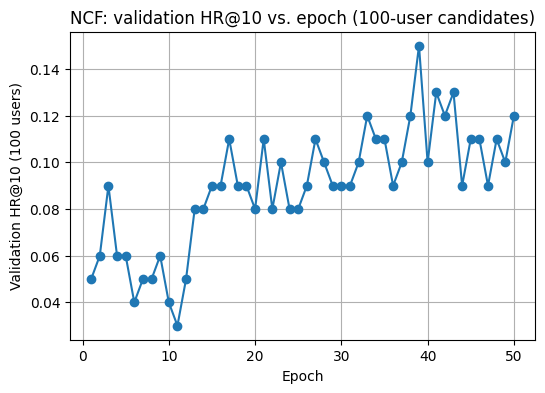

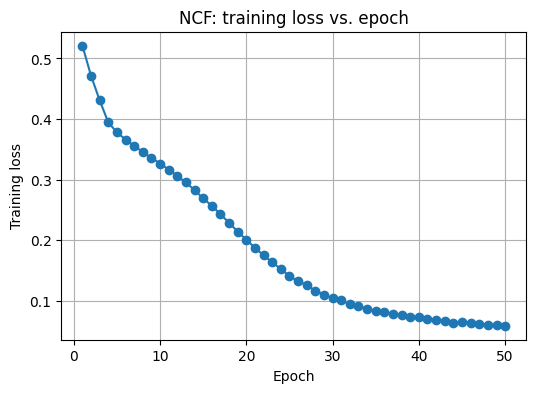

Best epoch based on 100-user val HR@10 = 39 (HR@10 = 0.1500)


In [48]:
epochs = range(1, len(val_hr_history) + 1)

plt.figure()
plt.plot(epochs, val_hr_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation HR@10 (100 users)")
plt.title("NCF: validation HR@10 vs. epoch (100-user candidates)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, train_loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("NCF: training loss vs. epoch")
plt.grid(True)
plt.show()

best_epoch = int(np.argmax(val_hr_history) + 1)
best_hr = float(max(val_hr_history))
print(f"Best epoch based on 100-user val HR@10 = {best_epoch} (HR@10 = {best_hr:.4f})")

## 10. Final Training Using the Selected Best Epoch

This cell retrains the NCF model from scratch using the best epoch
identified earlier.

It also measures the total training time, which will be used in
method comparison with other models (e.g., LLM rerankers).

In [49]:
 FINAL_EPOCHS = best_epoch

print(f"Retraining final NCF model for {FINAL_EPOCHS} epochs...")

final_ds = NCFDataset(
    train_idx[["uid", "iid"]],
    num_items=num_items,
    num_neg=NEG_PER_POS,
)
final_loader = DataLoader(
    final_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

final_model = NCF(num_users=num_users, num_items=num_items).to(device)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=LR)
final_criterion = nn.BCELoss()

start_train = time.time()

for epoch in range(1, FINAL_EPOCHS + 1):
    final_model.train()
    total_loss = 0.0

    for users, items, labels in tqdm(final_loader, desc=f"Final train epoch {epoch}"):
        users = users.view(-1).to(device)
        items = items.view(-1).to(device)
        labels = labels.view(-1).to(device)

        final_optimizer.zero_grad()
        preds = final_model(users, items)
        loss = final_criterion(preds, labels)
        loss.backward()
        final_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(final_loader)
    print(f"Epoch {epoch}: loss = {avg_loss:.4f}")

end_train = time.time()
train_time_seconds = end_train - start_train
print(f"\nTotal training time for {FINAL_EPOCHS} epochs: {train_time_seconds:.2f} seconds")

Retraining final NCF model for 39 epochs...


Final train epoch 1: 100%|██████████| 119/119 [00:04<00:00, 27.43it/s]


Epoch 1: loss = 0.5136


Final train epoch 2: 100%|██████████| 119/119 [00:04<00:00, 28.21it/s]


Epoch 2: loss = 0.4710


Final train epoch 3: 100%|██████████| 119/119 [00:04<00:00, 28.76it/s]


Epoch 3: loss = 0.4292


Final train epoch 4: 100%|██████████| 119/119 [00:04<00:00, 28.38it/s]


Epoch 4: loss = 0.3957


Final train epoch 5: 100%|██████████| 119/119 [00:04<00:00, 27.64it/s]


Epoch 5: loss = 0.3789


Final train epoch 6: 100%|██████████| 119/119 [00:04<00:00, 27.89it/s]


Epoch 6: loss = 0.3684


Final train epoch 7: 100%|██████████| 119/119 [00:04<00:00, 27.54it/s]


Epoch 7: loss = 0.3567


Final train epoch 8: 100%|██████████| 119/119 [00:03<00:00, 30.51it/s]


Epoch 8: loss = 0.3474


Final train epoch 9: 100%|██████████| 119/119 [00:04<00:00, 29.69it/s]


Epoch 9: loss = 0.3373


Final train epoch 10: 100%|██████████| 119/119 [00:04<00:00, 28.68it/s]


Epoch 10: loss = 0.3264


Final train epoch 11: 100%|██████████| 119/119 [00:03<00:00, 30.53it/s]


Epoch 11: loss = 0.3170


Final train epoch 12: 100%|██████████| 119/119 [00:03<00:00, 30.32it/s]


Epoch 12: loss = 0.3051


Final train epoch 13: 100%|██████████| 119/119 [00:03<00:00, 29.80it/s]


Epoch 13: loss = 0.2915


Final train epoch 14: 100%|██████████| 119/119 [00:03<00:00, 30.57it/s]


Epoch 14: loss = 0.2790


Final train epoch 15: 100%|██████████| 119/119 [00:04<00:00, 28.36it/s]


Epoch 15: loss = 0.2668


Final train epoch 16: 100%|██████████| 119/119 [00:03<00:00, 30.50it/s]


Epoch 16: loss = 0.2512


Final train epoch 17: 100%|██████████| 119/119 [00:03<00:00, 30.57it/s]


Epoch 17: loss = 0.2365


Final train epoch 18: 100%|██████████| 119/119 [00:03<00:00, 30.13it/s]


Epoch 18: loss = 0.2216


Final train epoch 19: 100%|██████████| 119/119 [00:03<00:00, 29.81it/s]


Epoch 19: loss = 0.2086


Final train epoch 20: 100%|██████████| 119/119 [00:04<00:00, 28.94it/s]


Epoch 20: loss = 0.1944


Final train epoch 21: 100%|██████████| 119/119 [00:04<00:00, 27.45it/s]


Epoch 21: loss = 0.1797


Final train epoch 22: 100%|██████████| 119/119 [00:04<00:00, 28.44it/s]


Epoch 22: loss = 0.1689


Final train epoch 23: 100%|██████████| 119/119 [00:04<00:00, 28.12it/s]


Epoch 23: loss = 0.1580


Final train epoch 24: 100%|██████████| 119/119 [00:04<00:00, 28.21it/s]


Epoch 24: loss = 0.1469


Final train epoch 25: 100%|██████████| 119/119 [00:04<00:00, 26.36it/s]


Epoch 25: loss = 0.1386


Final train epoch 26: 100%|██████████| 119/119 [00:04<00:00, 26.42it/s]


Epoch 26: loss = 0.1308


Final train epoch 27: 100%|██████████| 119/119 [00:04<00:00, 27.83it/s]


Epoch 27: loss = 0.1231


Final train epoch 28: 100%|██████████| 119/119 [00:04<00:00, 27.98it/s]


Epoch 28: loss = 0.1158


Final train epoch 29: 100%|██████████| 119/119 [00:03<00:00, 31.21it/s]


Epoch 29: loss = 0.1111


Final train epoch 30: 100%|██████████| 119/119 [00:03<00:00, 32.83it/s]


Epoch 30: loss = 0.1068


Final train epoch 31: 100%|██████████| 119/119 [00:04<00:00, 28.83it/s]


Epoch 31: loss = 0.1028


Final train epoch 32: 100%|██████████| 119/119 [00:04<00:00, 27.96it/s]


Epoch 32: loss = 0.0988


Final train epoch 33: 100%|██████████| 119/119 [00:03<00:00, 30.01it/s]


Epoch 33: loss = 0.0959


Final train epoch 34: 100%|██████████| 119/119 [00:03<00:00, 29.77it/s]


Epoch 34: loss = 0.0925


Final train epoch 35: 100%|██████████| 119/119 [00:03<00:00, 31.27it/s]


Epoch 35: loss = 0.0908


Final train epoch 36: 100%|██████████| 119/119 [00:03<00:00, 30.68it/s]


Epoch 36: loss = 0.0871


Final train epoch 37: 100%|██████████| 119/119 [00:03<00:00, 31.92it/s]


Epoch 37: loss = 0.0851


Final train epoch 38: 100%|██████████| 119/119 [00:03<00:00, 31.49it/s]


Epoch 38: loss = 0.0816


Final train epoch 39: 100%|██████████| 119/119 [00:03<00:00, 31.41it/s]

Epoch 39: loss = 0.0802

Total training time for 39 epochs: 158.94 seconds


## 11. Evaluation on 100 Users (Candidate Pools)

This cell evaluates the final model on the 100-user candidate pools,
computing:
1. HR@5, HR@10, HR@20,
2. NDCG@5, NDCG@10, NDCG@20.

It also measures the evaluation time, which is required for runtime comparison.

In [50]:
Ks = [5, 10, 20]

results_val_100 = {}
results_test_100 = {}

print("\n100-user Validation (candidate pools)")
start_val_100 = time.time()
for k in Ks:
    print(f"\n[100-user Validation] top-{k}")
    metrics_k = eval_on_candidates(final_model, cand_val_100, val_tgt_100, topk=k)
    results_val_100[k] = metrics_k
end_val_100 = time.time()
val_100_eval_time = end_val_100 - start_val_100
print(f"\nTotal 100-user validation eval time: {val_100_eval_time:.4f} seconds")

print("\n100-user Test (candidate pools)")
start_test_100 = time.time()
for k in Ks:
    print(f"\n[100-user Test] top-{k}")
    metrics_k = eval_on_candidates(final_model, cand_test_100, test_tgt_100, topk=k)
    results_test_100[k] = metrics_k
end_test_100 = time.time()
test_100_eval_time = end_test_100 - start_test_100
print(f"\nTotal 100-user test eval time: {test_100_eval_time:.4f} seconds")

print("\nSummary – 100-user Validation:")
for k in Ks:
    m = results_val_100[k]
    print(f"K={k}: HR={m['HR']:.4f}, NDCG={m['NDCG']:.4f}")

print("\nSummary – 100-user Test:")
for k in Ks:
    m = results_test_100[k]
    print(f"K={k}: HR={m['HR']:.4f}, NDCG={m['NDCG']:.4f}")


100-user Validation (candidate pools)

[100-user Validation] top-5


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2540.74it/s]


Evaluated users: 100
HR@5: 0.0400
NDCG@5: 0.0202
Precision@5: 0.0080
F1@5: 0.0133

[100-user Validation] top-10


Eval users: 100%|██████████| 100/100 [00:00<00:00, 3208.84it/s]


Evaluated users: 100
HR@10: 0.0900
NDCG@10: 0.0357
Precision@10: 0.0090
F1@10: 0.0164

[100-user Validation] top-20


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2291.02it/s]


Evaluated users: 100
HR@20: 0.2200
NDCG@20: 0.0683
Precision@20: 0.0110
F1@20: 0.0210

Total 100-user validation eval time: 0.1277 seconds

100-user Test (candidate pools)

[100-user Test] top-5


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2705.37it/s]


Evaluated users: 100
HR@5: 0.0500
NDCG@5: 0.0218
Precision@5: 0.0100
F1@5: 0.0167

[100-user Test] top-10


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2741.11it/s]


Evaluated users: 100
HR@10: 0.0700
NDCG@10: 0.0285
Precision@10: 0.0070
F1@10: 0.0127

[100-user Test] top-20


Eval users: 100%|██████████| 100/100 [00:00<00:00, 2939.76it/s]

Evaluated users: 100
HR@20: 0.2000
NDCG@20: 0.0606
Precision@20: 0.0100
F1@20: 0.0190

Total 100-user test eval time: 0.1203 seconds

Summary – 100-user Validation:
K=5: HR=0.0400, NDCG=0.0202
K=10: HR=0.0900, NDCG=0.0357
K=20: HR=0.2200, NDCG=0.0683

Summary – 100-user Test:
K=5: HR=0.0500, NDCG=0.0218
K=10: HR=0.0700, NDCG=0.0285
K=20: HR=0.2000, NDCG=0.0606


## 12. Full-Ranking Evaluation on All Users

This cell evaluates NCF on every user in the dataset using full-item ranking.

For each user:
1. all unseen items are scored,
2. the top-K items are extracted,
3. HR/NDCG@5, 10, 20 are computed.

Evaluation time is recorded for comparison with the 100-user evaluation.

In [51]:
results_val_all = {}
results_test_all = {}

print("\nAll-users Validation (full ranking)")
start_val_all = time.time()
for k in Ks:
    print(f"\n[All-users Validation] top-{k}")
    metrics_k = eval_full_ranking(
        final_model,
        val_tgt_all,
        user_pos_all,
        num_items=num_items,
        topk=k,
        max_users=None,
    )
    results_val_all[k] = metrics_k
end_val_all = time.time()
val_all_eval_time = end_val_all - start_val_all
print(f"\nTotal all-users validation eval time: {val_all_eval_time:.4f} seconds")

print("\nAll-users Test (full ranking)")
start_test_all = time.time()
for k in Ks:
    print(f"\n[All-users Test] top-{k}")
    metrics_k = eval_full_ranking(
        final_model,
        test_tgt_all,
        user_pos_all,
        num_items=num_items,
        topk=k,
        max_users=None,
    )
    results_test_all[k] = metrics_k
end_test_all = time.time()
test_all_eval_time = end_test_all - start_test_all
print(f"\nTotal all-users test eval time: {test_all_eval_time:.4f} seconds")

print("\nSummary – All-users Validation:")
for k in Ks:
    m = results_val_all[k]
    print(f"K={k}: HR={m['HR']:.4f}, NDCG={m['NDCG']:.4f}")

print("\nSummary – All-users Test:")
for k in Ks:
    m = results_test_all[k]
    print(f"K={k}: HR={m['HR']:.4f}, NDCG={m['NDCG']:.4f}")

print("\nTime Summary (seconds)")
print(f"Training time: {train_time_seconds:.4f}")
print(f"100-user val eval time: {val_100_eval_time:.4f}")
print(f"100-user test eval time: {test_100_eval_time:.4f}")
print(f"All-users val eval time: {val_all_eval_time:.4f}")
print(f"All-users test eval time: {test_all_eval_time:.4f}")


All-users Validation (full ranking)

[All-users Validation] top-5


Eval all-users: 100%|██████████| 13587/13587 [04:14<00:00, 53.35it/s]


Evaluated users: 13586
HR@5: 0.0029
NDCG@5: 0.0014
Precision@5: 0.0006
F1@5: 0.0010

[All-users Validation] top-10


Eval all-users: 100%|██████████| 13587/13587 [04:12<00:00, 53.71it/s]


Evaluated users: 13586
HR@10: 0.0077
NDCG@10: 0.0029
Precision@10: 0.0008
F1@10: 0.0014

[All-users Validation] top-20


Eval all-users: 100%|██████████| 13587/13587 [04:05<00:00, 55.41it/s]


Evaluated users: 13586
HR@20: 0.0177
NDCG@20: 0.0054
Precision@20: 0.0009
F1@20: 0.0017

Total all-users validation eval time: 752.8762 seconds

All-users Test (full ranking)

[All-users Test] top-5


Eval all-users: 100%|██████████| 12918/12918 [03:46<00:00, 57.03it/s]


Evaluated users: 12890
HR@5: 0.0014
NDCG@5: 0.0008
Precision@5: 0.0003
F1@5: 0.0005

[All-users Test] top-10


Eval all-users: 100%|██████████| 12918/12918 [03:43<00:00, 57.81it/s]


Evaluated users: 12890
HR@10: 0.0031
NDCG@10: 0.0013
Precision@10: 0.0003
F1@10: 0.0006

[All-users Test] top-20


Eval all-users: 100%|██████████| 12918/12918 [03:58<00:00, 54.14it/s]

Evaluated users: 12890
HR@20: 0.0085
NDCG@20: 0.0026
Precision@20: 0.0004
F1@20: 0.0008

Total all-users test eval time: 688.5938 seconds

Summary – All-users Validation:
K=5: HR=0.0029, NDCG=0.0014
K=10: HR=0.0077, NDCG=0.0029
K=20: HR=0.0177, NDCG=0.0054

Summary – All-users Test:
K=5: HR=0.0014, NDCG=0.0008
K=10: HR=0.0031, NDCG=0.0013
K=20: HR=0.0085, NDCG=0.0026

Time Summary (seconds)
Training time: 158.9449
100-user val eval time: 0.1277
100-user test eval time: 0.1203
All-users val eval time: 752.8762
All-users test eval time: 688.5938
